# Statistical analysis of scRNA-seq with metabolic labeling data

Here you will learn how to analyze the statistical properties of new RNA counts using cell-specific chi-square test and total RNA counts using chi-square independence test.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn
import numpy as np
import StatisticalFeatures
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(scanpy=True, fontsize=6)

## Load and preprocess the data

The analysis is based on the cell cycle dataset. To run analysis on your own data, read your fileto an AnnData object with adata = dyn.read('file name'). 

In [2]:
# load data
filename = './data/rpe1.h5ad'
rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

rpe1_kinetics_without_spliced = rpe1_kinetics.copy()

rpe1_kinetics_without_spliced.layers['new'], rpe1_kinetics_without_spliced.layers['total'] = rpe1_kinetics_without_spliced.layers['ul'] + rpe1_kinetics_without_spliced.layers['sl'], \
                                                             rpe1_kinetics_without_spliced.layers['su'] + rpe1_kinetics_without_spliced.layers['sl'] + \
                                                             rpe1_kinetics_without_spliced.layers['uu'] + rpe1_kinetics_without_spliced.layers['ul']

del rpe1_kinetics_without_spliced.layers['uu'], rpe1_kinetics_without_spliced.layers['ul'], rpe1_kinetics_without_spliced.layers['su'], rpe1_kinetics_without_spliced.layers['sl']

del rpe1,rpe1_kinetics

Preprocessing includes steps such as selecting highly variable genes. Since the parameter inference methods of CSP and CSZIP require raw counts, you need to set **keep_raw_layers=True**.

In [3]:
dyn.preprocessing.recipe_monocle(
    rpe1_kinetics_without_spliced,
    tkey='time',
    experiment_type="kin",
    reset_X=True,
    X_total_layers=False,
    splicing_total_layers=False,
    n_top_genes=1000,
    total_layers=True,
    keep_filtered_cells=False,
    keep_filtered_genes=True,
    keep_raw_layers=True,
)

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache ]
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
35 input query terms found no hit:
	['ENS

## New RNA counts analysis using cell-specific chi-square test

Here we fit new RNA counts with CSP and CSZIP models for highly variable genes and set the significance level at 0.05 for cell-specific chi-square tests.

In [4]:
gene_list = rpe1_kinetics_without_spliced[:,rpe1_kinetics_without_spliced.var['use_for_pca']].var.index.tolist()
significance = 0.05 # significance level of hypothesis testing

###  Test whether the new RNA counts obeys the cell specific Poisson (CSP) distribution

In [5]:
model = 'CSP'
result_flag_CSP, p_value_CSP, f_obs_CSP, f_exp_CSP = StatisticalFeatures.new_counts_statistical_features(
    rpe1_kinetics_without_spliced, gene_list, model, significance)

average_reject_rate = np.mean(result_flag_CSP == 0, axis=0)
average_accept_rate = np.mean(result_flag_CSP == 1, axis=0)
average_unable_to_determine_rate = np.mean(result_flag_CSP == 2, axis=0)
CSP_average_rate = pd.DataFrame(np.stack((average_accept_rate, average_reject_rate, 
    average_unable_to_determine_rate)), columns = result_flag_CSP.columns, index=[
    'average_accept_rate','average_reject_rate','average_unable_to_determine_rate'])
CSP_average_rate

Test whether the new mRNA counts obeys the cell specific Poisson distribution: 1000it [20:11,  1.21s/it]


,0.25,0.5,0.75,1.0,2.0,3.0
average_accept_rate,0.116,0.067,0.049,0.062,0.064,0.065
average_reject_rate,0.278,0.568,0.655,0.652,0.695,0.725
average_unable_to_determine_rate,0.606,0.365,0.296,0.286,0.241,0.210


The results showed that some of the genes were well fitted by the CSP model. Also the proportion of genes that could not be determined decreased as the labeling duration increased.

### Test whether the new RNA obeys the cell specific zero-inflated Poisson (CSZIP) distribution

In [6]:
model = 'CSZIP'
result_flag_CSZIP, p_value_CSZIP, f_obs_CSZIP, f_exp_CSZIP = StatisticalFeatures.new_counts_statistical_features(
    rpe1_kinetics_without_spliced, gene_list, model, significance)

average_reject_rate = np.mean(result_flag_CSZIP == 0, axis=0)
average_accept_rate = np.mean(result_flag_CSZIP == 1, axis=0)
average_unable_to_determine_rate = np.mean(result_flag_CSZIP == 2, axis=0)
CSZIP_average_rate = pd.DataFrame(np.stack((average_accept_rate, average_reject_rate, 
    average_unable_to_determine_rate)), columns = result_flag_CSZIP.columns, index=[
    'average_accept_rate','average_reject_rate','average_unable_to_determine_rate'])
CSZIP_average_rate

Test whether the new RNA obeys the cell specific zero-inflated Poisson distribution: 1000it [20:35,  1.24s/it]


,0.25,0.5,0.75,1.0,2.0,3.0
average_accept_rate,0.351,0.467,0.472,0.476,0.459,0.459
average_reject_rate,0.055,0.189,0.266,0.274,0.327,0.344
average_unable_to_determine_rate,0.594,0.344,0.262,0.250,0.214,0.197


The results show that a significant proportion of genes are well fitted by the CSZIP model, implying that for highly variable genes, the CSZIP model fits better compared to the CSP model.

### Plot the fit results of some typical genes

Next, we visualize the results of some gene observed counts fitted by the CSP model and the CSZIP model.

Change the matplotlib settings for better visualization:

In [7]:
figsize = (1.5, 1.5)
dpi = 150
save_path = None
cut_value = None

Visualization of fitting results of gene RPL41 with low expression:

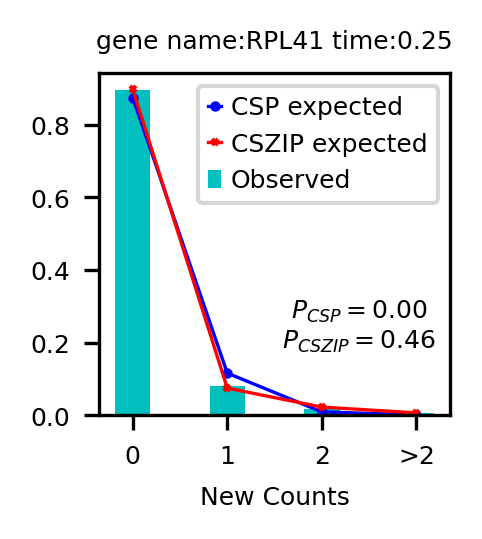

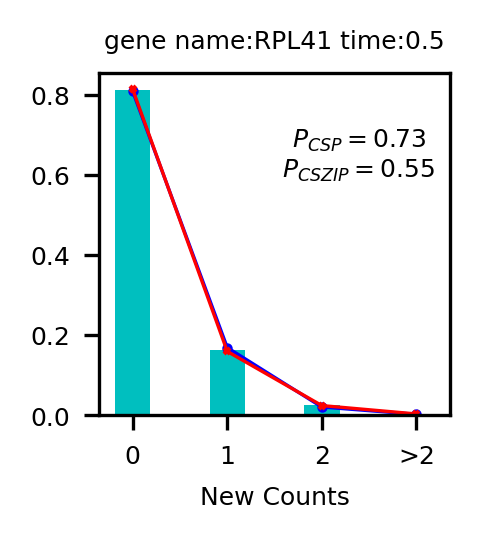

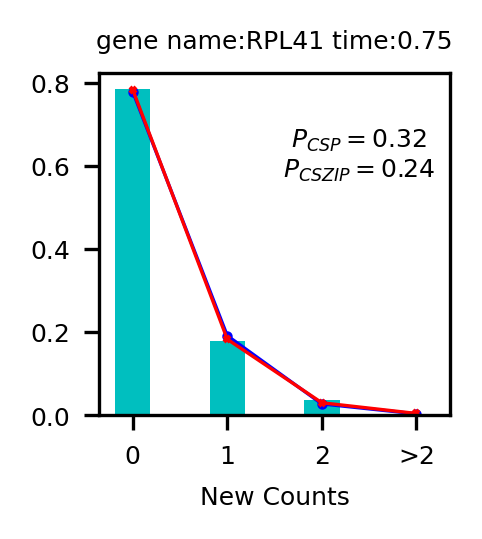

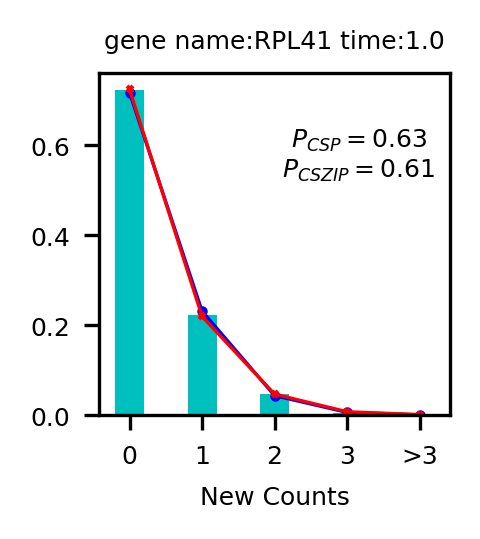

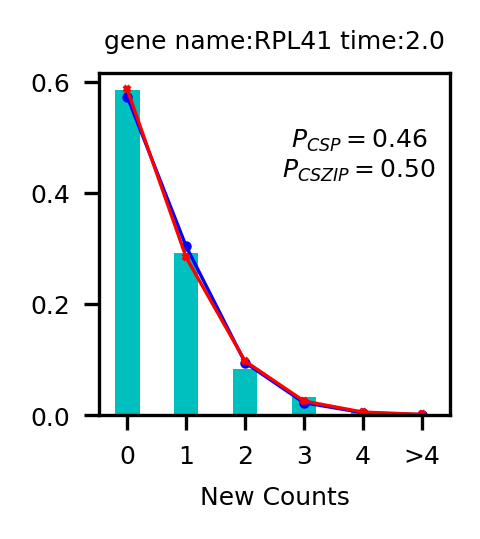

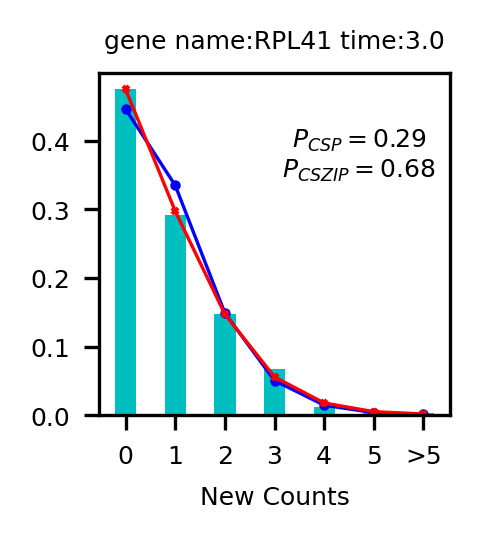

In [8]:
gene_name = 'RPL41'
StatisticalFeatures.plot_new_RNA_counts_fitting_results(f_obs_CSP, f_obs_CSZIP, f_exp_CSP, f_exp_CSZIP,
                                                        p_value_CSP, p_value_CSZIP, gene_name, figsize, dpi, cut_value, save_path)

Visualization of fitting results of gene IL22RA1 with high expression:

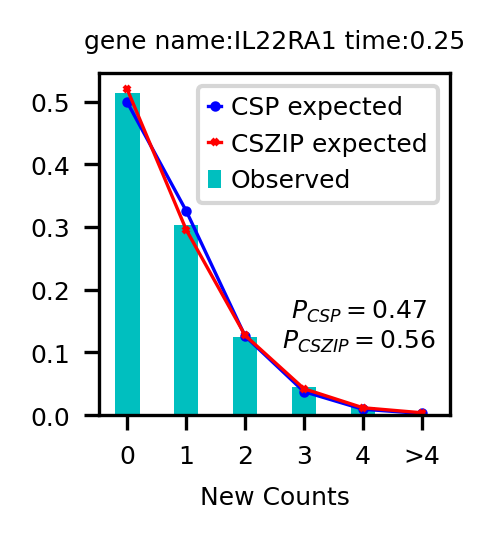

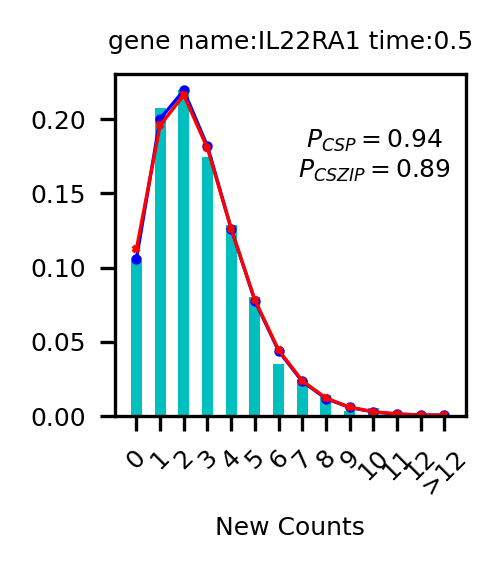

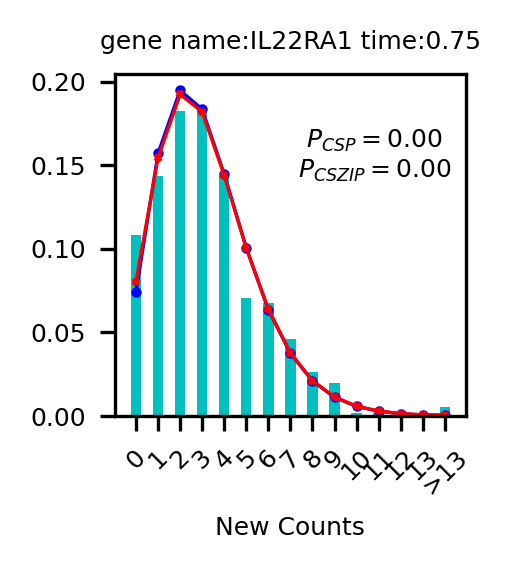

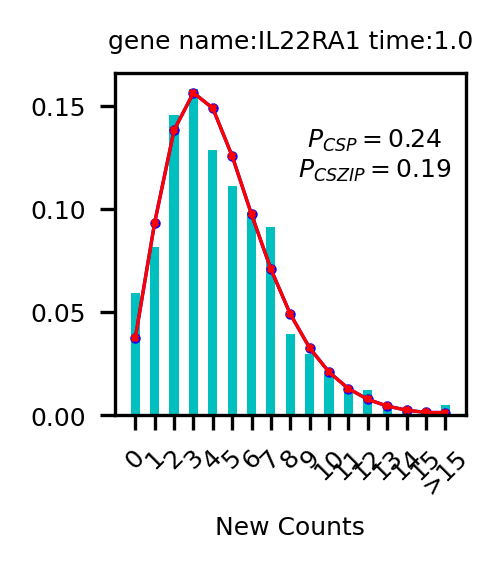

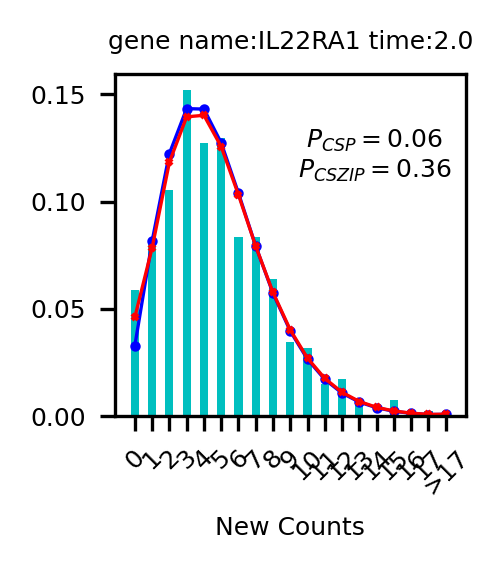

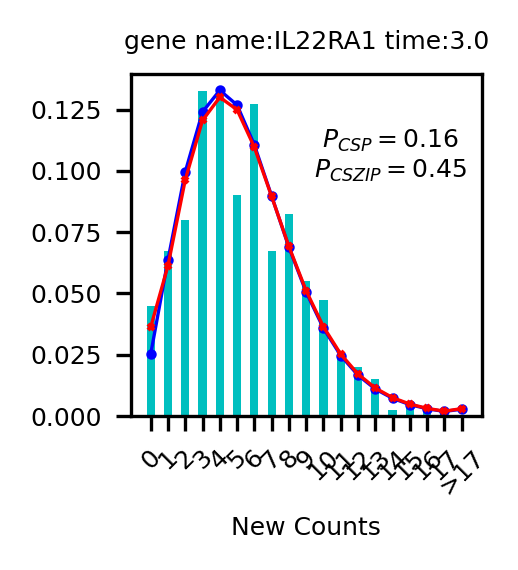

In [9]:
gene_name = 'IL22RA1'
StatisticalFeatures.plot_new_RNA_counts_fitting_results(f_obs_CSP, f_obs_CSZIP, f_exp_CSP, f_exp_CSZIP,
                                                        p_value_CSP, p_value_CSZIP, gene_name, figsize, dpi, cut_value, save_path)

## Total RNA counts analysis using chi-square independence tests

We used the chi-square independence test to check whether the total RNA counts of different labeling durations in highly variable genes obeyed the same distribution, and here the significance level was set at 0.05.

In [10]:
gene_list = rpe1_kinetics_without_spliced[:, rpe1_kinetics_without_spliced.var['use_for_pca']].var.index.tolist()
significance = 0.05

### Results of the chi-square independence test

In [11]:
result_flag, p_value, f_obs = StatisticalFeatures.total_counts_statistical_features(
    rpe1_kinetics_without_spliced, gene_list, significance)
average_reject_rate = np.mean(result_flag == 0)
average_accept_rate = np.mean(result_flag == 1)
average_unable_to_determine_rate = np.mean(result_flag == 2)
print(f'average_accept_rate:{average_accept_rate}\naverage_reject_rate:{average_reject_rate}\naverage_unable_to_determine_rate:{average_unable_to_determine_rate}')

Test whether total RNA counts obeyed the same distribution via chi-square independence test: 1000it [00:00, 1136.91it/s]

average_accept_rate:0.723
average_reject_rate:0.277
average_unable_to_determine_rate:0.0


### Results visualization

Change the matplotlib settings for better visualization:

In [12]:
figsize=(1.61,1.61)
dpi = 150

#### Visualize the average acceptance, rejection and undetermined percentage with pie charts:

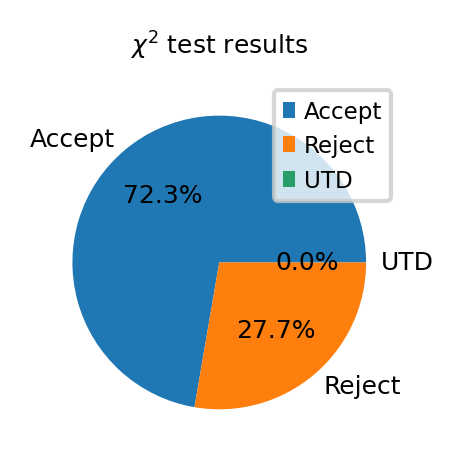

In [13]:
X = [average_accept_rate, average_reject_rate, average_unable_to_determine_rate]
plt.figure(figsize=figsize,dpi=dpi)
plt.pie(X, labels=['Accept', 'Reject', 'UTD'], autopct='%.1f%%')
plt.legend()
plt.title('$\chi^{2}$ test results')
# plt.savefig('./Figures/dataset1/test/Total_figure/chi_results.pdf', dpi=150, bbox_inches="tight")
plt.show()

The results show that a significant proportion of the total mRNA counts of genes with different labeling durations obey the same distribution.

#### Plot the fit results of some typical genes

We visualize the results of some typical genes.

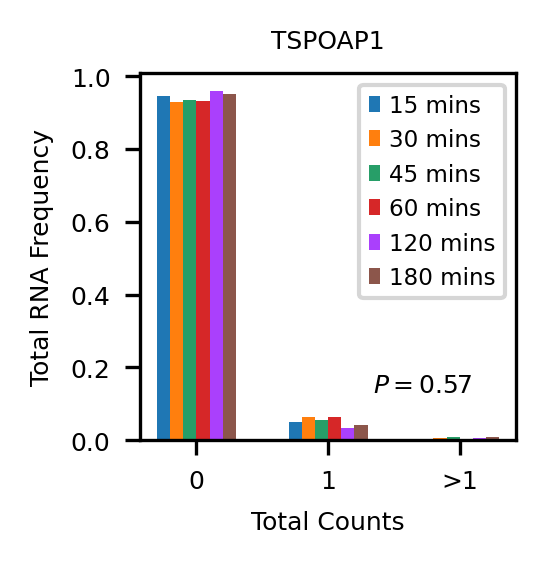

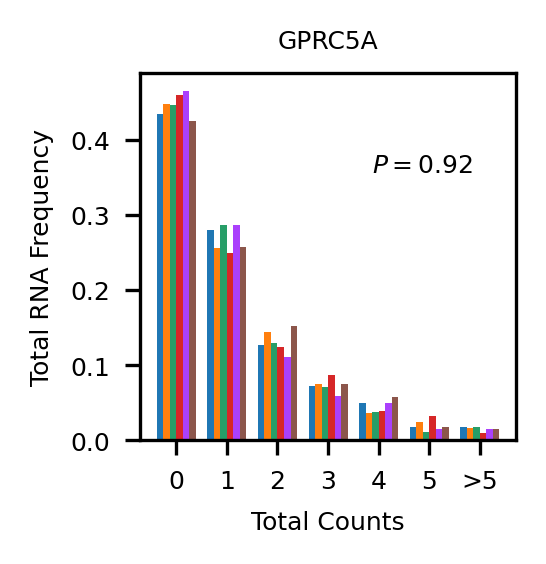

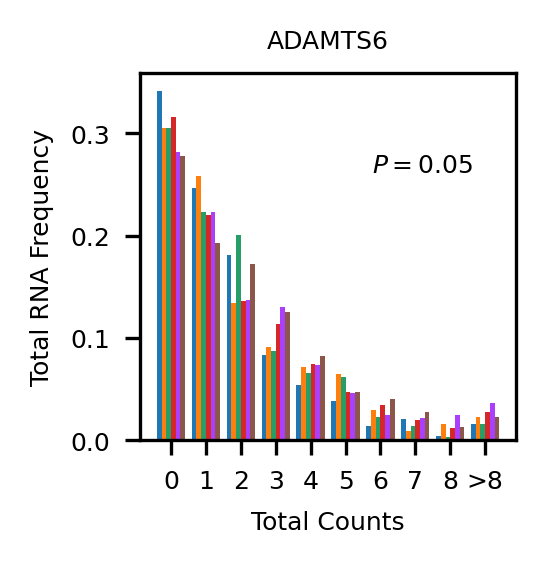

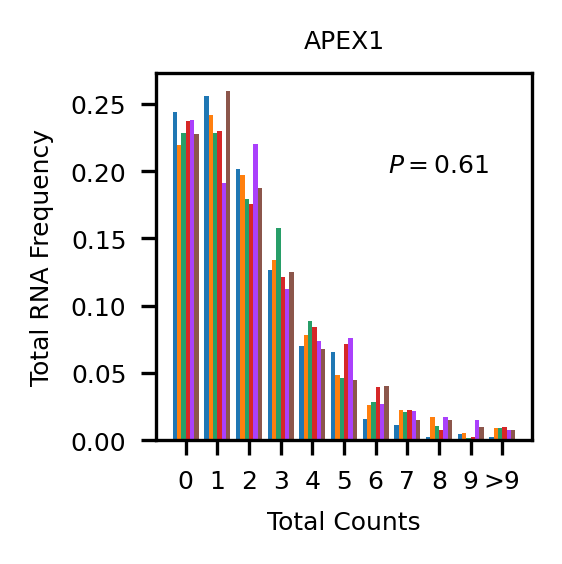

In [14]:
gene_name_list = ['TSPOAP1', 'GPRC5A', 'ADAMTS6', 'APEX1']
# save_path = './Figures/dataset1/test/Total_figure/'
save_path = None
StatisticalFeatures.plot_total_RNA_counts_fitting_results(f_obs, p_value, gene_name_list, figsize, dpi, save_path)